In [ ]:
!pip install ta-lib

# Gpu

In [ ]:
!nvidia-smi

Wed Aug 20 20:41:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Set_Up

In [ ]:
process = 'Train'
symbol = 'XAUUSD'
direction = 'L'
root_data = f'/content/drive/MyDrive/Course Folder/Forex/{symbol}/'
print(root_data)

rolling_window = 100

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from typing import Sequence, Tuple, Dict, Any, List, Callable
import random

import sys
sys.path.append("..")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!conda list ta-lib
import talib as ta
print(ta.__version__)
print(help(ta.ATR))

## Strategy

In [ ]:
def kalman_line(source, kalman_length: int, smooth: int):

    n = len(source)
    kf_c = np.empty(n)            # núcleo del filtro
    velo_c = np.zeros(n)          # componente de velocidad

    sqrt_term   = np.sqrt(kalman_length / 10000.0 * 2.0)
    length_term = kalman_length / 10000.0

    # --------- inicialización (mismo efecto que `var` en Pine) ----------
    kf_c[0]   = source.iloc[0]    # nz(kf_c[1], source) para la primera barra
    velo_c[0] = 0.0

    # ------------------- bucle recursivo -------------------------------
    for i in range(1, n):
        prev_kf = kf_c[i-1] if not np.isnan(kf_c[i-1]) else source.iloc[i]
        dk      = source.iloc[i] - prev_kf
        smooth_c = prev_kf + dk * sqrt_term          # parte "suave"
        velo_c[i] = velo_c[i-1] + length_term * dk   # acumulamos velocidad
        kf_c[i]   = smooth_c + velo_c[i]             # estimación final

    # -------------------- EMA final (ta.ema) ----------------------------
    kf_c_series = pd.Series(kf_c, index=source.index)
    kalman_line = kf_c_series.ewm(span=smooth, adjust=False).mean()
    return kalman_line


In [ ]:
def insta(src: Sequence[float], a: float) -> Tuple[np.ndarray, np.ndarray]:

    src = np.asarray(src, dtype=float)
    n = src.size
    it = np.full(n, np.nan)
    lag = np.full(n, np.nan)

    def get(arr, i):
        return arr[i] if 0 <= i < n else np.nan

    def nz(x, y):
        return x if not np.isnan(x) else y

    for i in range(n):
        s0 = get(src, i)
        s1 = get(src, i - 1)
        s2 = get(src, i - 2)

        # Fallback used inside nz(..., fallback)
        fallback = (s0 + 2 * s1 + s2) / 4 if not (
            np.isnan(s0) or np.isnan(s1) or np.isnan(s2)
        ) else np.nan

        it_prev1 = get(it, i - 1)
        it_prev2 = get(it, i - 2)

        term1 = (a - (a * a) / 4.0) * s0
        term2 = 0.5 * a * a * s1 if not np.isnan(s1) else 0.0
        term3 = -(a - 0.75 * a * a) * s2 if not np.isnan(s2) else 0.0
        term4 = 2 * (1 - a) * nz(it_prev1, fallback)
        term5 = (1 - a) * (1 - a) * nz(it_prev2, fallback)

        # Full recursive update (mirrors Pine order)
        value_it = term1 + term2 + term3 + term4 - term5
        it[i] = value_it

        # lag = 2 * it - nz(it[2])
        it_prev2_for_lag = get(it, i - 2)
        lag[i] = 2 * it[i] - it_prev2_for_lag if not np.isnan(it_prev2_for_lag) else np.nan

    return lag, it

# Data

In [ ]:
#/content/drive/MyDrive/Course Folder/Forex/XAUUSD/Data/XAUUSD_M5.csv

data = pd.read_csv(root_data + 'Data/'+symbol+'_M5.csv', index_col=0)
data.index = pd.to_datetime(data.index)
time_difference = data.index.max() - data.index.min()
number_of_days = time_difference.days
data = data.reset_index()
data['ATR'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)

print(f"The data DataFrame covers a period of {number_of_days} days.")
print('Shape', data.shape)
data.tail()

In [ ]:
#data = data.iloc[0:50000]
#data = data.iloc[-100000:]
data.shape

(100000, 8)

In [ ]:
# data.head()

# Strategy

In [ ]:
data['hl2'] = (data['High'] + data['Low'])/ 2

alpha_1 = 0.025
alpha_2 = 0.14
alpha_3 = 0.18

data['lag_1'], data['it_1'] = insta(data['hl2'], alpha_1)
data['lag_2'], data['it_2'] = insta(data['hl2'], alpha_2)
data['lag_3'], data['it_3'] = insta(data['hl2'], alpha_3)

In [ ]:
bullish_condition = (data['lag_1'] > data['it_1']) & \
                    (data['lag_2'] > data['it_2']) & \
                    (data['lag_3'] > data['it_3'])

bearish_condition = (data['lag_1'] < data['it_1']) & \
                    (data['lag_2'] < data['it_2']) & \
                    (data['lag_3'] < data['it_3'])

data['Open_Trade_1'] = np.where(bullish_condition, 1, np.where(bearish_condition, -1, np.nan))
data['Open_Trade'] = np.where(data['Open_Trade_1'] == data['Open_Trade_1'].shift(1), np.nan, data['Open_Trade_1'])

close_bearish_condition = data['Open_Trade'] == 1
close_bullish_condition = data['Open_Trade'] == -1

data['Close_Trade_1'] = np.where(close_bearish_condition, -1, np.where(close_bullish_condition, 1, np.nan))
data['st_Close_Trade'] = np.where(data['Close_Trade_1'] == data['Close_Trade_1'].shift(1), np.nan, data['Close_Trade_1'])

data = data.drop(columns=['Open_Trade_1', 'Close_Trade_1'])
#data

In [ ]:
data['Entry_Date'] = pd.NaT
data.loc[data['Open_Trade'] ==  1, 'Entry_Date'] = data['Date'][data['Open_Trade'] == 1]
data.loc[data['Open_Trade'] == -1, 'Entry_Date'] = data['Date'][data['Open_Trade'] == -1]

data['Type'] = np.nan
data.loc[data['Open_Trade'] ==  1, 'Type'] = 'Long'
data.loc[data['Open_Trade'] == -1, 'Type'] = 'Short'
#data.loc[data['Open_Trade'] == -1, 'Type'] = 'Short'
#data['Type'] = data['Type'].ffill()

data['Trade_Number'] = np.nan
start_mask = data["Entry_Date"].notna() & data["Type"].notna()

data["Trade_Number"] = start_mask.cumsum()
first_trade = data["Trade_Number"].ne(0).idxmax()
data.loc[: first_trade - 1, "Trade_Number"] = np.nan
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'ATR',
       'hl2', 'lag_1', 'it_1', 'lag_2', 'it_2', 'lag_3', 'it_3', 'Open_Trade',
       'st_Close_Trade', 'Entry_Date', 'Type', 'Trade_Number'],
      dtype='object')

In [ ]:
columns_to_see = ['Date', 'Close','Open_Trade', 'Type', 'Entry_Date','st_Exit_Date','Trade_Number']

data.loc[data['Open_Trade'].notna(), :].head(10)
data.loc[((data['Open_Trade'].notna()) & (data['Type']=='Short')), :].head(10)


,Date,Open,High,Low,Close,Volume,Spread,ATR,hl2,lag_1,it_1,lag_2,it_2,lag_3,it_3,Open_Trade,st_Close_Trade,Entry_Date,Type,Trade_Number
325369,2024-02-07 07:40:00,2033.93,2034.48,2033.76,2034.01,189,5,0.466811,2034.120,2036.461049,2036.488665,2034.468168,2034.834363,2034.259092,2034.702718,-1.0,1.0,2024-02-07 07:40:00,Short,2.0
325400,2024-02-07 10:15:00,2034.02,2034.29,2033.00,2033.68,341,5,0.739889,2033.645,2035.796122,2035.832711,2034.569929,2034.921270,2034.333848,2034.810652,-1.0,1.0,2024-02-07 10:15:00,Short,4.0
325411,2024-02-07 11:10:00,2032.98,2033.26,2032.70,2033.15,315,5,0.788703,2032.980,2034.906105,2035.024736,2032.898486,2032.947611,2032.925772,2032.928501,-1.0,1.0,2024-02-07 11:10:00,Short,5.0
325422,2024-02-07 12:05:00,2033.73,2033.82,2033.20,2033.48,214,5,0.768690,2033.510,2034.867719,2034.887996,2034.175535,2034.233324,2034.153252,2034.334921,-1.0,1.0,2024-02-07 12:05:00,Short,7.0
325443,2024-02-07 13:50:00,2034.16,2034.16,2033.40,2033.60,272,5,0.714361,2033.780,2034.588195,2034.591194,2034.353087,2034.552656,2034.241967,2034.609215,-1.0,1.0,2024-02-07 13:50:00,Short,9.0
325459,2024-02-07 15:10:00,2032.94,2033.15,2032.39,2032.73,426,5,0.911139,2032.770,2033.713916,2033.785289,2032.825916,2032.828622,2032.885025,2032.917455,-1.0,1.0,2024-02-07 15:10:00,Short,10.0
325476,2024-02-07 16:35:00,2033.94,2036.88,2032.94,2036.74,733,5,1.550119,2034.910,2034.833546,2034.845329,2034.820945,2035.619739,2034.324622,2035.378975,-1.0,1.0,2024-02-07 16:35:00,Short,12.0
325507,2024-02-07 19:10:00,2036.50,2036.50,2035.20,2035.67,528,5,1.486834,2035.850,2038.898340,2038.999059,2036.944568,2037.957487,2036.404508,2037.574607,-1.0,1.0,2024-02-07 19:10:00,Short,16.0
325524,2024-02-07 20:35:00,2035.38,2035.44,2035.00,2035.39,344,5,1.202287,2035.220,2037.399179,2037.539356,2035.380909,2035.440274,2035.481931,2035.579683,-1.0,1.0,2024-02-07 20:35:00,Short,17.0
325542,2024-02-07 22:05:00,2035.40,2035.44,2034.97,2035.00,146,5,0.683635,2035.205,2036.262102,2036.348971,2035.317132,2035.317828,2035.357062,2035.395434,-1.0,1.0,2024-02-07 22:05:00,Short,18.0


# PnL_Original

## Functions

In [ ]:
def st_pnl_close(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 1) ensure Date is datetime & sorted
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # 2) initialize PnL column
    df['st_row_PnL_close'] = np.nan

    # 3) pick only true entry‐rows: longs open_trade==1, shorts open_trade==-1
    entries = df[
        ((df['Type'] == 'Long')  & (df['Open_Trade'] == 1)) |
        ((df['Type'] == 'Short') & (df['Open_Trade'] == -1))
    ]

    for _, trade in entries.iterrows():
        entry    = trade['Entry_Date']
        exit_    = trade['st_Exit_Date'] if pd.notna(trade['st_Exit_Date']) else entry
        base     = trade['Close']
        mask     = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            # long: profit = (close - base) * 100
            df.loc[mask, 'st_row_PnL_close'] = (df.loc[mask, 'Close'] - base) * 100
        else:
            # short: profit = (base - close) * 100
            df.loc[mask, 'st_row_PnL_close'] = (base - df.loc[mask, 'Close']) * 100

    return df


def st_pnl_low(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df['st_row_PnL_Low'] = np.nan

    opens = df[df['Type'].notna()]
    for _, trade in opens.iterrows():
        entry = trade['Entry_Date']
        exit_ = trade['st_Exit_Date']

        # Buscar el precio de cierre en la fecha de entrada
        base_row = df[df['Date'] == entry]
        if base_row.empty:
            continue  # Saltar si no se encuentra esa fecha
        base = base_row.iloc[0]['Close']

        mask = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            df.loc[mask, 'st_row_PnL_low'] = (df.loc[mask, 'Low'] - base) * 100
        elif trade['Type'] == 'Short':
            df.loc[mask, 'st_row_PnL_low'] = (base - df.loc[mask, 'Low']) * 100

    return df

def st_pnl_high(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df['st_row_PnL_high'] = np.nan

    opens = df[df['Type'].notna()]
    for _, trade in opens.iterrows():
        entry = trade['Entry_Date']
        exit_ = trade['st_Exit_Date']

        # Buscar el precio de cierre en la fecha de entrada
        base_row = df[df['Date'] == entry]
        if base_row.empty:
            continue  # Saltar si no se encuentra esa fecha
        base = base_row.iloc[0]['Close']

        mask = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            df.loc[mask, 'st_row_PnL_high'] = (df.loc[mask, 'High'] - base) * 100
        elif trade['Type'] == 'Short':
            df.loc[mask, 'st_row_PnL_high'] = (base - df.loc[mask, 'High']) * 100

    return df

In [ ]:
def st_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['st_Exit_Date'] = pd.NaT

    long_entries = df[df['Open_Trade'] == 1]
    short_entries = df[df['Open_Trade'] == -1]
    short_signals = df['Date'][df['Open_Trade'] == -1]
    long_signals = df['Date'][df['Open_Trade'] == 1]

    for index, row in long_entries.iterrows():
        next_short_signal_date = short_signals[short_signals > row['Date']]
        if not next_short_signal_date.empty:
            exit_index = df[df['Date'] == next_short_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']

    for index, row in short_entries.iterrows():
        next_long_signal_date = long_signals[long_signals > row['Date']]
        if not next_long_signal_date.empty:
            exit_index = df[df['Date'] == next_long_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']
    return df

In [ ]:
def st_duration(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['st_Duration'] = pd.NaT
    trade_rows = df[df['Type'].isin(['Long', 'Short'])]
    df.loc[trade_rows.index, 'st_Duration'] = (trade_rows['st_Exit_Date'] - trade_rows['Entry_Date']).dt.total_seconds() / 60
    return df

In [ ]:
def st_max_min(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['st_Exit_Date']  = pd.to_datetime(df['st_Exit_Date'])

    df['st_Max'] = np.nan
    df['st_Min'] = np.nan

    opens = df[df['Type'].notna()]
    for idx, trade in opens.iterrows():
        entry    = trade['Entry_Date']
        exit_dt  = trade['st_Exit_Date']
        # hallar la fila de exit_dt y retroceder una
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
        else:
            continue

        mask = (df['Date'] >= entry) & (df['Date'] <= prev_date)
        # Consider max/min across the three specified columns within the mask
        subset_df = df.loc[mask, ['st_row_PnL_close', 'st_row_PnL_low', 'st_row_PnL_high']]

        if not subset_df.empty:
            # Calculate max and min across the relevant columns for the masked rows
            df.at[idx, 'st_Max'] = subset_df.values.max()
            df.at[idx, 'st_Min'] = subset_df.values.min()

    return df

In [ ]:
def st_trade_type(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['trade_type'] = np.nan

    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])

    trade_entries = df[df['Type'].isin(['Long', 'Short'])].copy()

    for index, trade in trade_entries.iterrows():
        entry_date = trade['Entry_Date']
        exit_date = trade['st_Exit_Date']
        trade_type = trade['Type']

        # Find the index of the row before the Exit_Date
        exit_rows = df.index[df['Date'] == exit_date]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
        else:
            # If no valid exit date, consider the trade open until the end of the data
            prev_date = df['Date'].max()


        mask = (df['Date'] >= entry_date) & (df['Date'] <= prev_date)

        if trade_type == 'Long':
            df.loc[mask, 'trade type'] = 1
        elif trade_type == 'Short':
            df.loc[mask, 'trade type'] = 0

    return df

In [ ]:
def st_pnl(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])
    df['st_PnL'] = np.nan

    pnl_by_date = df.set_index('Date')['st_row_PnL_close']
    entries = df[df['Type'].isin(['Long', 'Short'])]
    for idx, trade in entries.iterrows():
        exit_dt = trade['st_Exit_Date']
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
            df.at[idx, 'st_PnL'] = pnl_by_date.get(prev_date, np.nan)

    return df

In [ ]:
def PnL_trade_analytics_table(df: pd.DataFrame):
    """
    Calcula métricas de rendimiento de trades con los siguientes formatos:
      • Total PnL, Avg Profit y Avg Loss → $ con separador de miles, 0 decimales
      • Win (%) y Loss (%) → 2 decimales + símbolo %
      • Profit Factor → 2 decimales
      • # Days y conteos → separador de miles
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # ──────────────────── Cálculo numérico ────────────────────
    analytics = pd.DataFrame(index=['Strategy'])
    analytics['# Days'] = (df['Date'].max() - df['Date'].min()).days
    analytics['Total PnL']  = round(df.st_PnL.sum(), 0)
    analytics['Total Trades'] = df.st_PnL.count()
    analytics['Number of Winners'] = (df.st_PnL > 0).sum()
    analytics['Number of Losers']  = (df.st_PnL <= 0).sum()
    analytics['Win (%)']  = round(100 * analytics.at['Strategy','Number of Winners'] /
                                  analytics.at['Strategy','Total Trades'], 2)
    analytics['Loss (%)'] = round(100 * analytics.at['Strategy','Number of Losers']  /
                                  analytics.at['Strategy','Total Trades'], 2)
    analytics['Average Profit of Winning Trade'] = round(df.loc[df.st_PnL > 0, 'st_PnL'].mean(), 0)
    analytics['Average Loss of Losing Trade']    = round(abs(df.loc[df.st_PnL < 0, 'st_PnL'].mean()), 0)

    if {'Entry_Date','st_Exit_Date'}.issubset(df.columns):
        df['Entry_Date']   = pd.to_datetime(df['Entry_Date'])
        df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])
        analytics['Average Holding Time'] = (df['st_Exit_Date'] - df['Entry_Date']).mean()

    tot_profit   = df.loc[df.st_PnL > 0, 'st_PnL'].sum()
    tot_loss_abs = abs(df.loc[df.st_PnL < 0, 'st_PnL'].sum())
    analytics['Profit Factor'] = round(tot_profit / tot_loss_abs, 2) if tot_loss_abs else np.nan

    # ──────────────────── Formato visual ────────────────────
    def _fmt(val, metric):
        if metric in ('Win (%)', 'Loss (%)'):
            return f'{val:,.2f}%'
        if metric in ('Total PnL',
                      'Average Profit of Winning Trade',
                      'Average Loss of Losing Trade'):
            return f'$ {val:,.0f}'
        if metric in ('# Days', 'Total Trades', 'Number of Winners', 'Number of Losers'):
            return f'{val:,.0f}'
        if metric in ('Profit Factor',):
            return f'{val:,.2f}'
        return val

    styled = analytics.T.copy()
    styled['Strategy'] = [ _fmt(v, idx) for idx, v in styled['Strategy'].items() ]

    return (styled.style
                  .set_caption('')
                  .set_table_styles([
                      {'selector':'th','props':[('font-weight','bold'), ('text-align','center')]},
                      {'selector':'td','props':[('text-align','center')]},
                      {'selector':'thead th', 'props':[('text-align','center')]}
                  ]))


## Implementation

In [ ]:
data = st_exit_date(data)
print(data.shape)
data = st_trade_type(data)
print(data.shape)
data = st_duration(data)
print(data.shape)
data = st_pnl_close(data)
print(data.shape)
data = st_pnl_high(data)
print(data.shape)
data = st_pnl_low(data)
print(data.shape)
data = st_max_min(data)
print(data.shape)
data = st_pnl(data)
print(data.shape)
print(data.columns)

(100000, 21)
(100000, 23)
(100000, 24)
(100000, 25)
(100000, 26)
(100000, 28)
(100000, 30)
(100000, 31)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'ATR',
       'hl2', 'lag_1', 'it_1', 'lag_2', 'it_2', 'lag_3', 'it_3', 'Open_Trade',
       'st_Close_Trade', 'Entry_Date', 'Type', 'Trade_Number', 'st_Exit_Date',
       'trade_type', 'trade type', 'st_Duration', 'st_row_PnL_close',
       'st_row_PnL_high', 'st_row_PnL_Low', 'st_row_PnL_low', 'st_Max',
       'st_Min', 'st_PnL'],
      dtype='object')


In [ ]:
columns_to_see = ['Date', 'Close','Low','High','Open_Trade', 'Type', 'trade type', 'Entry_Date','st_Close_Trade','st_Exit_Date', 'st_Duration',
                  'st_row_PnL_high', 'st_row_PnL_low', 'st_row_PnL_close','st_Max', 'st_Min', 'st_PnL']

data.loc[data['Open_Trade'].notna(), columns_to_see].head(10)
#data.loc[((data['Open_Trade'].notna()) & (data['Type']=='Short')), columns_to_see].head(10)

### Long
#data.loc[(data['Date']>= '2020-02-25 05:35:00') & (data['Date']<= '2020-02-25 06:15:00'),columns_to_see]
#data.loc[(data['Date']>= '2020-02-25 10:20:00') & (data['Date']<= '2020-02-25 13:30:00'),columns_to_see]

### Short
#data.loc[(data['Date']>= '2020-02-25 09:15:00') & (data['Date']<= '2020-02-25 10:20:00'),columns_to_see]
#data.loc[(data['Date']>= '2020-02-25 06:15:00') & (data['Date']<= '2020-02-25 10:20:00'),columns_to_see]

#data.tail(5)

In [ ]:
data.to_csv(root_data+'Results/'+symbol+'_M5_Original_PnL.csv')

In [ ]:
data_st_pnl = data.copy()
data_st_pnl = data_st_pnl[data_st_pnl['Entry_Date'].notna()]
#data_sl_pnl.head(5)

In [ ]:
st_columns = ['Date', 'Type', 'Entry_Date', 'st_Exit_Date', 'st_PnL','st_Duration']

#data.loc[data['Entry_Date']!=0, st_columns]

#data.loc[(data['Open_Trade']!=0) & (data['st_Max']>400), sl_columns]

#data.loc[(data['Date']>= '2019-07-08 03:10:00') & (data['Date']<= '2019-07-08 04:30:00'),  st_columns]
#data.loc[(data['Date']>= '2019-07-08 02:30:00') & (data['Date']<= '2019-07-08 04:30:00'), st_columns]

#data.loc[(data['Date']>= '2019-08-26 05:05:00') & (data['Date']<= '2019-08-26 08:05:00'),st_columns]

In [ ]:
trade_analysis = PnL_trade_analytics_table(data_st_pnl)
trade_analysis

,Strategy
# Days,513
Total PnL,"$ -2,706,451"
Total Trades,"9,289"
Number of Winners,515
Number of Losers,"8,774"
Win (%),5.54%
Loss (%),94.46%
Average Profit of Winning Trade,$ 183
Average Loss of Losing Trade,$ 322
Average Holding Time,0 days 03:14:26.605662611


In [ ]:
print(data_st_pnl['st_PnL'].sum())

-2706450.999999998


## Plots

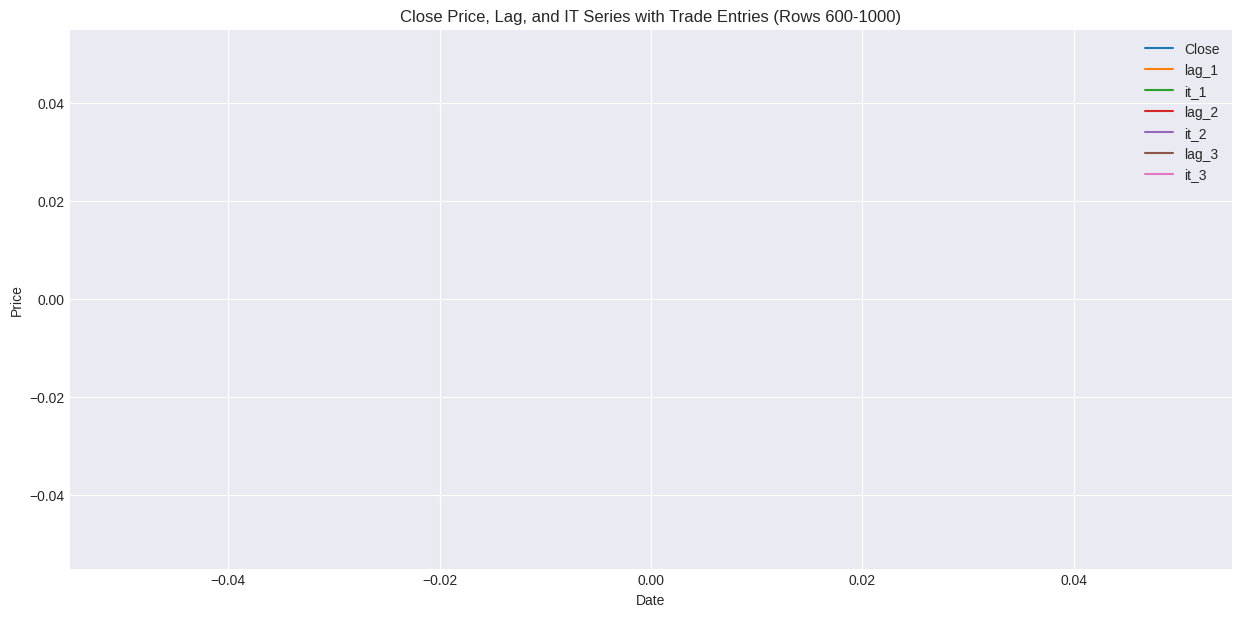

In [ ]:
# Select the data for plotting
aaa = 425300
bbb = 425500

plot_data_subset = data.iloc[aaa:bbb][['Close', 'hl2', 'Open_Trade']]

# Add lag and it columns to the subset
plot_data_subset['lag_1'] = data['lag_1'].iloc[aaa:bbb]
plot_data_subset['it_1']  = data['it_1'].iloc[aaa:bbb]
plot_data_subset['lag_2'] = data['lag_2'].iloc[aaa:bbb]
plot_data_subset['it_2']  = data['it_2'].iloc[aaa:bbb]
plot_data_subset['lag_3'] = data['lag_3'].iloc[aaa:bbb]
plot_data_subset['it_3']  = data['it_3'].iloc[aaa:bbb]


# Plot the data
plt.figure(figsize=(15, 7))
plt.plot(plot_data_subset.index, plot_data_subset['Close'], label='Close')
plt.plot(plot_data_subset.index, plot_data_subset['lag_1'], label='lag_1')
plt.plot(plot_data_subset.index, plot_data_subset['it_1'], label='it_1')
plt.plot(plot_data_subset.index, plot_data_subset['lag_2'], label='lag_2')
plt.plot(plot_data_subset.index, plot_data_subset['it_2'], label='it_2')
plt.plot(plot_data_subset.index, plot_data_subset['lag_3'], label='lag_3')
plt.plot(plot_data_subset.index, plot_data_subset['it_3'], label='it_3')

# Add vertical lines for trade entries
for index, row in plot_data_subset.iterrows():
    if row['Open_Trade'] == 1:
        plt.axvline(x=index, color='green', linestyle='--', lw=1)
    elif row['Open_Trade'] == -1:
        plt.axvline(x=index, color='red', linestyle='--', lw=1)


plt.title('Close Price, Lag, and IT Series with Trade Entries (Rows 600-1000)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# SL_Dyn

## Functions

In [ ]:
def SL_PnL(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['SL_PnL'] = np.nan

    entries = out[out['Type'].isin(['Long', 'Short'])]

    for idx, row in entries.iterrows():
        m = (out['Date'] >= row['Entry_Date']) & (out['Date'] <= row['st_Exit_Date'])
        out.at[idx, 'SL_PnL'] = out.loc[m, 'dyn_stoploss'].max()

    return out

def SL_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asigna SL_Exit_Date y SL_Duration tomando la fecha de la fila donde se determinó SL_PnL.
    Requiere que la columna 'SL_PnL' ya exista (producida por SL_PnL()).
    """
    if 'SL_PnL' not in df.columns:
        raise ValueError("Debe ejecutar primero SL_PnL() para crear la columna 'SL_PnL'.")

    out = df.copy()
    out['Date'] = pd.to_datetime(out['Date'])
    out['Entry_Date'] = pd.to_datetime(out['Entry_Date'])
    out['st_Exit_Date'] = pd.to_datetime(out['st_Exit_Date'])

    out['SL_Exit_Date'] = pd.NaT
    out['SL_Duration'] = np.nan

    trade_mask = out['Type'].isin(['Long', 'Short'])

    for idx, trade in out.loc[trade_mask].iterrows():
        entry = trade['Entry_Date']
        final_exit = trade['st_Exit_Date']
        sl_value = trade['SL_PnL']

        if pd.isna(entry) or pd.isna(final_exit) or pd.isna(sl_value):
            continue

        window_mask = (out['Date'] >= entry) & (out['Date'] <= final_exit)
        window = out.loc[window_mask]

        if window.empty:
            continue

        # Filas donde el dyn_stoploss coincide con el SL_PnL asignado a la operación
        candidates = window[window['dyn_stoploss'] == sl_value]
        if candidates.empty:
            continue

        # Segunda aparición si existe; si no, la primera
        target = candidates.iloc[1] if len(candidates) > 1 else candidates.iloc[0]
        sl_exit_date = target['Date']

        out.at[idx, 'SL_Exit_Date'] = sl_exit_date
        out.at[idx, 'SL_Duration'] = (sl_exit_date - entry).total_seconds() / 60.0

    return out

# ─────────────────────────────────────────────────────────────
# 3. SL_Duration  ─ minutos entre Entry_Date y SL_Exit_Date
# ─────────────────────────────────────────────────────────────
def SL_Duration(df: pd.DataFrame) -> pd.DataFrame:
    if 'SL_Exit_Date' not in df.columns:
        raise ValueError("La columna 'SL_Exit_Date' no existe. Ejecuta SL_Exit_Date() antes.")

    out = df.copy()
    out['SL_Duration'] = np.nan

    mask = out['Type'].isin(['Long', 'Short'])
    durations = (out.loc[mask, 'SL_Exit_Date'] - out.loc[mask, 'Entry_Date']) \
                  .dt.total_seconds() / 60.0
    out.loc[mask, 'SL_Duration'] = durations

    return out

In [ ]:
def SL_trade_analytics_table(df: pd.DataFrame):
    """
    Analiza resultados de trades SL con formatos visuales:
      • Total PnL, Avg Profit y Avg Loss → $ con separador de miles, 0 decimales
      • Win (%) y Loss (%) → 2 decimales + símbolo %
      • Profit Factor → 2 decimales
      • # Days y conteos → separador de miles
      • Estilo visual centrado y limpio
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # ──────────────────── Cálculo numérico ────────────────────
    analytics = pd.DataFrame(index=['Dynamic_SL'])
    analytics['# Days'] = (df['Date'].max() - df['Date'].min()).days
    analytics['Total PnL'] = round(df.SL_PnL.sum(), 0)
    analytics['Total Trades'] = df.SL_PnL.count()
    analytics['Number of Winners'] = (df.SL_PnL > 0).sum()
    analytics['Number of Losers']  = (df.SL_PnL <= 0).sum()
    analytics['Win (%)']  = round(100 * analytics.at['Dynamic_SL', 'Number of Winners'] /
                                  analytics.at['Dynamic_SL', 'Total Trades'], 2)
    analytics['Loss (%)'] = round(100 * analytics.at['Dynamic_SL', 'Number of Losers']  /
                                  analytics.at['Dynamic_SL', 'Total Trades'], 2)
    analytics['Average Profit of Winning Trade'] = round(df.loc[df.SL_PnL > 0, 'SL_PnL'].mean(), 0)
    analytics['Average Loss of Losing Trade']    = round(abs(df.loc[df.SL_PnL < 0, 'SL_PnL'].mean()), 0)

    if {'Entry_Date','SL_Exit_Date'}.issubset(df.columns):
        df['Entry_Date']   = pd.to_datetime(df['Entry_Date'])
        df['SL_Exit_Date'] = pd.to_datetime(df['SL_Exit_Date'])
        analytics['Average Holding Time'] = (df['SL_Exit_Date'] - df['Entry_Date']).mean()

    tot_profit   = df.loc[df.SL_PnL > 0, 'SL_PnL'].sum()
    tot_loss_abs = abs(df.loc[df.SL_PnL < 0, 'SL_PnL'].sum())
    analytics['Profit Factor'] = round(tot_profit / tot_loss_abs, 2) if tot_loss_abs else np.nan

    # ──────────────────── Formato visual ────────────────────
    def _fmt(val, metric):
        if metric in ('Win (%)', 'Loss (%)'):
            return f'{val:,.2f}%'
        if metric in ('Total PnL',
                      'Average Profit of Winning Trade',
                      'Average Loss of Losing Trade'):
            return f'${val:,.0f}'
        if metric in ('# Days', 'Total Trades', 'Number of Winners', 'Number of Losers'):
            return f'{val:,.0f}'
        if metric in ('Profit Factor',):
            return f'{val:,.2f}'
        return val

    styled = analytics.T.copy()
    styled['Dynamic_SL'] = [ _fmt(v, idx) for idx, v in styled['Dynamic_SL'].items() ]

    return (styled.style
                  .set_caption('')
                  .set_table_styles([
                      {'selector': 'th',  'props': [('font-weight','bold'), ('text-align','center')]},
                      {'selector': 'td',  'props': [('text-align','center')]},
                      {'selector': 'thead th', 'props': [('text-align','center')]}
                  ]))

In [ ]:
def SL_gen_fit_function(data: pd.DataFrame,
                       gen_initial_sl: float,
                       gen_first_step: float,
                       gen_gap_step: float) -> pd.DataFrame:

    df = SL_dyn(data.copy(), initial_sl=gen_initial_sl,
                   first_step=gen_first_step,
                   gap_first_step=gen_gap_step)

    df = SL_PnL(df)
    df = SL_exit_date(df)
    df = SL_Duration(df)
    total_sl_pnl = df['SL_PnL'].sum()

    summary = pd.DataFrame({
        'gen_initial_sl': [gen_initial_sl],
        'gen_first_step': [gen_first_step],
        'gen_gap_step': [gen_gap_step],
        'total_SL_PnL': [total_sl_pnl]
    })

    return summary

In [ ]:
def SL_dyn(data: pd.DataFrame,
           initial_sl: float = -200,
           first_step: float = 100,
           gap_first_step: float = 100) -> pd.DataFrame:
    """
    Crea la columna 'sl_dyn' con el valor del stop en cada fila.
    Mantiene las columnas 'atr_dyn' (existente) y '_atr_prev' (atr_dyn previo no-NaN).
    Marca NaN en 'sl_dyn' cuando cualquier PnL intrabarra cae por debajo de '_atr_prev'.
    """
    df = data.copy()

    # Nueva columna de stop dinámico
    col_name = 'sl_dyn'
    df[col_name] = np.nan

    # Validación y cálculo del ATR dinámico PREVIO (último válido antes de la fila)
    if 'atr_dyn' not in df.columns:
        raise KeyError("La columna 'atr_dyn' es requerida para esta lógica.")
    df['_atr_prev'] = df['atr_dyn'].ffill().shift(1)

    in_trade       = False
    trade_active   = False
    broken         = False
    sl_val         = initial_sl
    next_threshold = first_step

    for idx, row in df.iterrows():
        # 1) Apertura del trade
        if pd.notna(row.get('Entry_Date', np.nan)):
            in_trade       = True
            trade_active   = True
            broken         = False
            sl_val         = initial_sl
            next_threshold = first_step

            df.at[idx, col_name] = sl_val
            continue  # no evaluar más en la vela de entrada

        if in_trade:
            # Mejor PnL de la barra
            best_pnl = np.nanmax([
                row.get('st_row_PnL_high',  np.nan),
                row.get('st_row_PnL_low',   np.nan),
                row.get('st_row_PnL_close', np.nan)
            ])
            best_pnl = 0.0 if np.isnan(best_pnl) else float(best_pnl)

            if trade_active:
                # 2) Trailing por escalones
                while best_pnl >= next_threshold:
                    sl_val         += gap_first_step
                    next_threshold += gap_first_step

                # 3) Ruptura si cualquier PnL < ATR dinámico PREVIO
                atr_prev = row['_atr_prev']
                if pd.notna(atr_prev):
                    if (row.get('st_row_PnL_high',  np.inf)  < atr_prev or
                        row.get('st_row_PnL_low',   np.inf)  < atr_prev or
                        row.get('st_row_PnL_close', np.inf)  < atr_prev):
                        broken       = True
                        trade_active = False

            # 4) Escribir resultado en 'sl_dyn'
            df.at[idx, col_name] = np.nan if broken else sl_val

            # 5) Cierre oficial del trade
            if pd.notna(row.get('st_Exit_Date', np.nan)) and row.get('Date', None) == row.get('st_Exit_Date', None):
                in_trade     = False
                trade_active = False
                broken       = False

    return df

## Test

In [ ]:
initial_sl = -200
first_step = 100
gap_first_step = 50

data = SL_dyn(data, initial_sl, first_step, gap_first_step)
data = SL_PnL(data)
data = SL_exit_date(data)
data = SL_Duration(data)

In [ ]:
data.columns
#data.tail()

In [ ]:
sl_columns = ['Date', 'Type', 'Close', 'SL_Exit_Date', 'SL_Duration','st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_low',
               'dyn_stoploss', 'SL_PnL']

time_a = '2025-07-04 16:45:00'
time_b = '2025-07-04 17:00:00'

data.loc[data['Open_Trade'].notna(), sl_columns]
data.loc[(data['Date']>= time_a) & (data['Date']<= time_b), columns_to_see]

In [ ]:
data_sl_pnl = data.copy()
data_sl_pnl = data_sl_pnl[data_sl_pnl['Entry_Date'].notna()]
#data_sl_pnl.head(5)

In [ ]:
trade_analysis = SL_trade_analytics_table(data_sl_pnl)
trade_analysis

In [ ]:
print(data_sl_pnl['SL_PnL'].sum())

## Genetic

In [ ]:

try:
    from tqdm.auto import trange
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

# ================== FUNCTION_1 (Referencia) ==================
def SL_gen_fit_function(data: pd.DataFrame,
                        gen_initial_sl: float,
                        gen_first_step: float,
                        gen_gap_step: float) -> pd.DataFrame:

    df = SL_dyn(data.copy(),
                initial_sl=gen_initial_sl,
                first_step=gen_first_step,
                gap_first_step=gen_gap_step)

    df = SL_PnL(df)
    df = SL_exit_date(df)
    df = SL_Duration(df)
    total_sl_pnl = df['SL_PnL'].sum()

    summary = pd.DataFrame({
        'gen_initial_sl': [gen_initial_sl],
        'gen_first_step': [gen_first_step],
        'gen_gap_step':   [gen_gap_step],
        'total_SL_PnL':   [total_sl_pnl]
    })

    return summary

# ================== CONFIG ESPACIOS DE BÚSQUEDA ==================

GEN_INITIAL_SL = (-500, -100, 10)
GEN_FIRST_STEP = (10, 300, 10)
GEN_GAP_STEP   = (100, 200, 10)

def _discrete_space(low: float, high: float, step: float) -> np.ndarray:
    # Evita errores de punto flotante
    n = int(round((high - low) / step)) + 1
    return np.round(low + np.arange(n) * step, 10)

_SPACE_INIT  = _discrete_space(*GEN_INITIAL_SL)
_SPACE_FIRST = _discrete_space(*GEN_FIRST_STEP)
_SPACE_GAP   = _discrete_space(*GEN_GAP_STEP)


def _random_gene() -> Tuple[float, float, float]:
    return (np.random.choice(_SPACE_INIT),
            np.random.choice(_SPACE_FIRST),
            np.random.choice(_SPACE_GAP))

def _mutate_gene(gene: Tuple[float, float, float],
                 p_mut: float,
                 mut_span: int = 1) -> Tuple[float, float, float]:
    gi, gf, gg = gene
    if np.random.rand() < p_mut:
        gi = _SPACE_INIT[np.clip(np.where(_SPACE_INIT == gi)[0][0] +
                                 np.random.randint(-mut_span, mut_span+1),
                                 0, len(_SPACE_INIT)-1)]
    if np.random.rand() < p_mut:
        gf = _SPACE_FIRST[np.clip(np.where(_SPACE_FIRST == gf)[0][0] +
                                  np.random.randint(-mut_span, mut_span+1),
                                  0, len(_SPACE_FIRST)-1)]
    if np.random.rand() < p_mut:
        gg = _SPACE_GAP[np.clip(np.where(_SPACE_GAP == gg)[0][0] +
                                np.random.randint(-mut_span, mut_span+1),
                                0, len(_SPACE_GAP)-1)]
    return (gi, gf, gg)

def _crossover_gene(p1: Tuple[float, float, float],
                    p2: Tuple[float, float, float]) -> Tuple[float, float, float]:
    mask = np.random.randint(0, 2, 3).astype(bool)
    return tuple(np.where(mask, p1, p2))

# ================== GA PRINCIPAL (con tqdm) ==================
def run_ga_SL(
    data: pd.DataFrame,
    pop_size: int = 30,
    generations: int = 40,
    elitism: int = 2,
    p_crossover: float = 0.8,
    p_mutation: float = 0.2,
    tournament_k: int = 3,
    random_state: int | None = None,
    show_progress: bool = True,
    progress_every: int = 1,
    callback: Callable[[int, Tuple[float,float,float], float, List[Dict[str,Any]]], None] | None = None
) -> Tuple[Dict[str, float], pd.DataFrame]:
    """
    GA para maximizar total_profit. Muestra avance con tqdm o prints.

    Parameters
    ----------
    show_progress : bool
        Si True, imprime/progresa barras.
    progress_every : int
        Cada cuántas generaciones reportar (si no hay tqdm).
    callback : callable
        callback(gen, best_gene, best_fit, results_records)

    Returns
    -------
    best_params : dict
    results_df : DataFrame
    """

    if random_state is not None:
        np.random.seed(random_state)

    # Cache fitness
    fitness_cache: Dict[Tuple[float, float, float], float] = {}

    def evaluate(gene: Tuple[float, float, float]) -> float:
        if gene in fitness_cache:
            return fitness_cache[gene]
        res = SL_gen_fit_function(data, *gene)
        fit = float(res['total_SL_PnL'].iloc[0])
        fitness_cache[gene] = fit
        return fit

    # población inicial
    population: List[Tuple[float, float, float]] = [_random_gene() for _ in range(pop_size)]

    results_records: List[Dict[str, Any]] = []

    def tournament_select() -> Tuple[float, float, float]:
        idxs = np.random.choice(len(population), tournament_k, replace=False)
        contenders = [population[i] for i in idxs]
        fits = [evaluate(c) for c in contenders]
        return contenders[int(np.argmax(fits))]

    iterator = trange(generations, desc="GA SL", leave=False) if (_HAS_TQDM and show_progress) else range(generations)

    for gen in iterator:
        # evaluar y guardar
        for ind in population:
            fit = evaluate(ind)
            results_records.append({
                'generation':      gen,
                'gen_initial_sl': ind[0],
                'gen_first_step':   ind[1],
                'gen_gap_step':     ind[2],
                'total_SL_PnL':    fit
            })

        # ordenar y elitismo
        ranked = sorted(population, key=evaluate, reverse=True)
        best_gene = ranked[0]
        best_fit  = evaluate(best_gene)

        # progreso
        if _HAS_TQDM and show_progress:
            iterator.set_postfix(best_fit=f"{best_fit:,.2f}")
        elif show_progress and (gen % progress_every == 0):
            print(f"[Gen {gen:03d}] best_fit={best_fit:,.2f}  gene={best_gene}", flush=True)

        if callback is not None:
            callback(gen, best_gene, best_fit, results_records)

        # reproducir
        next_pop = ranked[:elitism]
        while len(next_pop) < pop_size:
            parent1 = tournament_select()
            parent2 = tournament_select()
            child = parent1
            if np.random.rand() < p_crossover:
                child = _crossover_gene(parent1, parent2)
            child = _mutate_gene(child, p_mutation)
            next_pop.append(child)

        population = next_pop

    # final
    best = max(population, key=evaluate)
    best_fit = evaluate(best)
    best_params = {
        'gen_initial_sl': best[0],
        'gen_first_step': best[1],
        'gen_gap_step'  : best[2],
        'total_SL_PnL'  : best_fit
    }

    results_df = (pd.DataFrame(results_records)
                    .drop_duplicates(subset=['gen_initial_sl','gen_first_step','gen_gap_step','generation'],
                                     keep='last')
                    .reset_index(drop=True))

    return best_params, results_df

In [ ]:
# ================== EJEMPLO DE USO ==================
best_params, results_SL = run_ga_SL(data, pop_size=40, generations=50, random_state=42)
print(best_params)
results_SL.to_csv(root_data + 'Results/'+symbol+'SL_Genetic_Results_M5.csv')
results_SL.tail()

In [ ]:
print(best_params)

In [ ]:
initial_sl = best_params['gen_initial_sl']
first_step_sl = best_params['gen_first_step']
gap_first_step_sl = best_params['gen_gap_step']

data = SL_dyn(data, initial_sl, first_step_sl, gap_first_step_sl)
data = SL_PnL(data)
data = SL_exit_date(data)
data = SL_Duration(data)
data[f'SL_PnL_{initial_sl}_{first_step}_{gap_first_step}'] = data['SL_PnL'].copy()

In [ ]:
data.to_csv(root_data+'Results/'+symbol+'_M5_Genetic_SL.csv')
data.columns

In [ ]:
sl_columns = ['Date', 'Type', 'Entry_Date', 'st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_low',
               'dyn_stoploss', 'SL_PnL', 'SL_Exit_Date', 'SL_Duration']

#data.loc[data['Entry_Date']!=0, sl_columns]

#data.loc[(data['Open_Trade']!=0) & (data['st_Max']>400), sl_columns]

data.loc[(data['Date']>= '2019-07-08 03:10:00') & (data['Date']<= '2019-07-08 04:30:00'),  sl_columns]
#data.loc[(data['Date']>= '2019-07-08 02:30:00') & (data['Date']<= '2019-07-08 04:30:00'), sl_columns]

#data.loc[(data['Date']>= '2019-08-26 05:05:00') & (data['Date']<= '2019-08-26 08:05:00'),sl_columns]

In [ ]:
data_sl_pnl = data.copy()
data_sl_pnl = data_sl_pnl[data_sl_pnl['Entry_Date'].notna()]
#data_sl_pnl.head(5)

In [ ]:
trade_analysis = SL_trade_analytics_table(data_sl_pnl)
trade_analysis

# ATR

## Functions

In [ ]:
def atr_multiples(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula tres métricas expresadas en múltiplos de ATR para cada barra
    comprendida entre la apertura (Entry_Date) y la penúltima barra antes del
    cierre (st_Exit_Date) de cada trade Long/Short.

    Se añaden/actualizan tres columnas:
        • atr_mult_close : usa el precio low (misma lógica del original “close”)
        • atr_mult_high  : usa high
        • atr_mult_low   : usa low

    El DataFrame se modifica in-place y se devuelve por conveniencia.
    """
    # ── asegurar tipos datetime --------------------------------------------
    for col in ('Date', 'Entry_Date', 'st_Exit_Date'):
        df[col] = pd.to_datetime(df[col])

    # ── inicializar columnas destino ---------------------------------------
    for col in ('atr_mult_close', 'atr_mult_high', 'atr_mult_low'):
        if col not in df.columns:
            df[col] = np.nan
        else:
            df[col].values[:] = np.nan   # limpiar si ya existían

    # ── iterar sobre cada trade abierto ------------------------------------
    trades = df[df['Type'].isin(['Long', 'Short'])]
    for _, trade in trades.iterrows():
        entry_dt = trade['Entry_Date']
        exit_dt  = trade['st_Exit_Date']
        base_px  = trade['close']
        atr_base = trade['ATR']
        is_long  = trade['Type'] == 'Long'

        # fila de salida y fecha previa
        exit_idx = df.index[df['Date'] == exit_dt]
        if exit_idx.empty or exit_idx[0] == 0:
            continue                    # no hay barra previa para medir
        prev_date = df.at[exit_idx[0] - 1, 'Date']

        # máscara de barras a rellenar
        mask = (df['Date'] >= entry_dt) & (df['Date'] <= prev_date)

        # --- close (usa low como en función original) ----------------------
        if is_long:
            df.loc[mask, 'atr_mult_close'] = (df.loc[mask, 'low']  - base_px) / atr_base
            df.loc[mask, 'atr_mult_high']  = (df.loc[mask, 'high'] - base_px) / atr_base
            df.loc[mask, 'atr_mult_low']   = (df.loc[mask, 'low']  - base_px) / atr_base
        else:  # Short
            df.loc[mask, 'atr_mult_close'] = (base_px - df.loc[mask, 'low'])  / atr_base
            df.loc[mask, 'atr_mult_high']  = (base_px - df.loc[mask, 'high']) / atr_base
            df.loc[mask, 'atr_mult_low']   = (base_px - df.loc[mask, 'low'])  / atr_base

    return df

In [ ]:
def atr_PnL(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['atr_PnL'] = np.nan

    entries = out[out['Type'].isin(['Long', 'Short'])]

    for idx, row in entries.iterrows():
        start = row['Entry_Date']
        end   = row['st_Exit_Date']
        if pd.isna(end):
            continue

        m = (out['Date'] >= start) & (out['Date'] <= end)
        if not m.any():
            continue

        # Serie numérica de la ventana del trade
        trade_window = pd.to_numeric(out.loc[m, 'atr_dyn'], errors='coerce')

        vals = trade_window.to_numpy()
        isn = np.isnan(vals)

        if isn.any():
            # Posición del primer NaN y valor inmediatamente anterior
            first_nan_pos = np.where(isn)[0][0]
            last_valid_value = vals[first_nan_pos - 1] if first_nan_pos > 0 else np.nan
        else:
            # Sin NaNs en la ventana: tomar el último valor válido
            last_valid_value = vals[-1] if vals.size > 0 else np.nan

        out.at[idx, 'atr_PnL'] = last_valid_value

    return out

def st_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['st_Exit_Date'] = pd.NaT

    long_entries = df[df['Open_Trade'] == 1]
    short_entries = df[df['Open_Trade'] == -1]
    short_signals = df['Date'][df['Open_Trade'] == -1]
    long_signals = df['Date'][df['Open_Trade'] == 1]

    for index, row in long_entries.iterrows():
        next_short_signal_date = short_signals[short_signals > row['Date']]
        if not next_short_signal_date.empty:
            exit_index = df[df['Date'] == next_short_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']

    for index, row in short_entries.iterrows():
        next_long_signal_date = long_signals[long_signals > row['Date']]
        if not next_long_signal_date.empty:
            exit_index = df[df['Date'] == next_long_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']
    return df


def atr_exit_date(df: pd.DataFrame) -> pd.DataFrame:

    out = df.copy()
    out['Date']        = pd.to_datetime(out['Date'])
    out['Entry_Date']  = pd.to_datetime(out['Entry_Date'])
    out['st_Exit_Date'] = pd.to_datetime(out['st_Exit_Date'])

    out['atr_Exit_Date'] = pd.NaT
    out['atr_Duration']  = np.nan

    trade_mask = out['Type'].isin(['Long', 'Short'])

    for idx, trade in out.loc[trade_mask].iterrows():
        entry = trade['Entry_Date']
        final_exit = trade['st_Exit_Date']

        if pd.isna(entry) or pd.isna(final_exit):
            continue

        window_mask = (out['Date'] >= entry) & (out['Date'] <= final_exit)
        window_df = out.loc[window_mask].copy()
        first_nan_idx_in_window = window_df['atr_dyn'].isna().idxmax()

        if pd.notna(first_nan_idx_in_window) and first_nan_idx_in_window > window_df.index[0]:

            exit_idx_in_original_df = first_nan_idx_in_window - 1
            exit_date = out.loc[exit_idx_in_original_df, 'Date']

            out.at[idx, 'atr_Exit_Date'] = exit_date
            out.at[idx, 'atr_Duration'] = (exit_date - entry).total_seconds() / 60.0
        elif pd.isna(first_nan_idx_in_window) and not window_df.empty:
             # If no NaN is found, the exit is the end of the window (st_Exit_Date)
             out.at[idx, 'atr_Exit_Date'] = final_exit
             out.at[idx, 'atr_Duration'] = (final_exit - entry).total_seconds() / 60.0


    return out

def atr_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asigna atr_Exit_Date y atr_Duration tomando la fecha de la fila donde se determinó atr_PnL.
    Requiere que 'atr_PnL' exista (ejecutar antes atr_PnL()).
    """
    if 'atr_PnL' not in df.columns:
        raise ValueError("Debe ejecutar primero atr_PnL() para crear la columna 'atr_PnL'.")

    out = df.copy()
    out['Date']        = pd.to_datetime(out['Date'])
    out['Entry_Date']  = pd.to_datetime(out['Entry_Date'])
    out['st_Exit_Date'] = pd.to_datetime(out['st_Exit_Date'])

    out['atr_Exit_Date'] = pd.NaT
    out['atr_Duration']  = np.nan

    trade_mask = out['Type'].isin(['Long', 'Short'])

    for idx, trade in out.loc[trade_mask].iterrows():
        entry = trade['Entry_Date']
        final_exit = trade['st_Exit_Date']
        atr_val = trade['atr_PnL']

        if pd.isna(entry) or pd.isna(final_exit) or pd.isna(atr_val):
            continue

        window = out[(out['Date'] >= entry) & (out['Date'] <= final_exit)]
        if window.empty:
            continue

        # Filas donde el atr_dyn coincide con el valor atr_PnL asignado
        candidates = window[window['atr_dyn'] == atr_val]
        if candidates.empty:
            continue

        # Segunda aparición si existe; si no, la primera
        target = candidates.iloc[1] if len(candidates) > 1 else candidates.iloc[0]
        exit_date = target['Date']

        out.at[idx, 'atr_Exit_Date'] = exit_date
        out.at[idx, 'atr_Duration'] = (exit_date - entry).total_seconds() / 60.0

    return out

# ─────────────────────────────────────────────────────────────
# 3. SL_Duration  ─ minutos entre Entry_Date y SL_Exit_Date

def atr_Duration(df: pd.DataFrame) -> pd.DataFrame:
    if 'atr_Exit_Date' not in df.columns:
        raise ValueError("La columna 'atr_Exit_Date' no existe. Ejecuta SL_Exit_Date() antes.")

    out = df.copy()
    out['atr_Duration'] = np.nan

    mask = out['Type'].isin(['Long', 'Short'])
    durations = (out.loc[mask, 'atr_Exit_Date'] - out.loc[mask, 'Entry_Date']) \
                  .dt.total_seconds() / 60.0
    out.loc[mask, 'atr_Duration'] = durations

    return out

In [ ]:
def atr_max_min(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['Exit_Date']  = pd.to_datetime(df['st_Exit_Date'])

    df['ATR_Max'] = np.nan
    df['ATR_Min'] = np.nan

    opens = df[df['Type'].notna()]
    for idx, trade in opens.iterrows():
        entry   = trade['Entry_Date']
        exit_dt = trade['Exit_Date']
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
        else:
            continue

        mask = (df['Date'] >= entry) & (df['Date'] <= prev_date)
        vals = df.loc[mask, 'atr_mult'].dropna()
        if not vals.empty:
            df.at[idx, 'ATR_Max'] = vals.max()
            df.at[idx, 'ATR_Min'] = vals.min()

    return df

In [ ]:
def atr_PnL_dollar(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    df['atr_PnL_dollar'] = np.nan

    mask = df['Type'].isin(['Long', 'Short']) & df['ATR'].notna() & df['atr_PnL'].notna()
    df.loc[mask, 'atr_PnL_dollar'] = (df.loc[mask, 'ATR'] * df.loc[mask, 'atr_PnL']) * 100

    return df

In [ ]:
def atr_trade_analytics_table(df: pd.DataFrame):
    """
    Analiza resultados de trades ATR con formatos visuales:
      • Total PnL, Avg Profit y Avg Loss → $ con separador de miles, 0 decimales
      • Win (%) y Loss (%) → 2 decimales + símbolo %
      • Profit Factor → 2 decimales
      • # Days y conteos → separador de miles
    Usa la columna 'atr_PnL_$' (creada por atr_PnL_dollar()).
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    analytics = pd.DataFrame(index =['ATR_Dyn'])
    analytics['# Days']            = (df['Date'].max() - df['Date'].min()).days
    analytics['Total PnL']         = round(df['atr_PnL_dollar'].sum(), 0)
    analytics['Total Trades']      = df['atr_PnL_dollar'].count()
    analytics['Number of Winners'] = (df['atr_PnL_dollar'] > 0).sum()
    analytics['Number of Losers']  = (df['atr_PnL_dollar'] < 0).sum()
    analytics['Win (%)']  = round(100 * analytics.at['ATR_Dyn', 'Number of Winners'] /
                                  analytics.at['ATR_Dyn', 'Total Trades'], 2)
    analytics['Loss (%)'] = round(100 * analytics.at['ATR_Dyn', 'Number of Losers']  /
                                  analytics.at['ATR_Dyn', 'Total Trades'], 2)
    analytics['Average Profit of Winning Trade'] = round(df.loc[df['atr_PnL_dollar'] > 0, 'atr_PnL_dollar'].mean(), 0)
    analytics['Average Loss of Losing Trade']    = round(abs(df.loc[df['atr_PnL_dollar'] < 0, 'atr_PnL_dollar'].mean()), 0)

    if {'Entry_Date','atr_Exit_Date'}.issubset(df.columns):
        df['Entry_Date']    = pd.to_datetime(df['Entry_Date'])
        df['atr_Exit_Date'] = pd.to_datetime(df['atr_Exit_Date'])
        analytics['Average Holding Time'] = (df['atr_Exit_Date'] - df['Entry_Date']).mean()

    tot_profit   = df.loc[df['atr_PnL_dollar'] > 0, 'atr_PnL_dollar'].sum()
    tot_loss_abs = abs(df.loc[df['atr_PnL_dollar'] < 0, 'atr_PnL_dollar'].sum())
    analytics['Profit Factor'] = round(tot_profit / tot_loss_abs, 2) if tot_loss_abs else np.nan

    def _fmt(val, metric):
        if metric in ('Win (%)', 'Loss (%)'):
            return f'{val:,.2f}%'
        if metric in ('Total PnL',
                      'Average Profit of Winning Trade',
                      'Average Loss of Losing Trade'):
            return f'${val:,.0f}'
        if metric in ('# Days', 'Total Trades', 'Number of Winners', 'Number of Losers'):
            return f'{val:,.0f}'
        if metric in ('Profit Factor',):
            return f'{val:,.2f}'
        return val

    styled = analytics.T.copy()
    styled['ATR_Dyn'] = [_fmt(v, idx) for idx, v in styled['ATR_Dyn'].items()]

    return (styled.style
                  .set_caption('')
                  .set_table_styles([
                      {'selector': 'th',  'props': [('font-weight','bold'), ('text-align','center')]},
                      {'selector': 'td',  'props': [('text-align','center')]},
                      {'selector': 'thead th', 'props': [('text-align','center')]}
                  ]))

In [ ]:

def atr_gen_fit_function(data: pd.DataFrame,
                         gen_atr_initial: float,
                         gen_atr_first:   float,
                         gen_atr_gap:     float) -> pd.DataFrame:
    df = atr_dyn(data.copy(),
                 initial_atr=gen_atr_initial,
                 first_step_atr=gen_atr_first,
                 gap_first_step_atr=gen_atr_gap)

    df = atr_PnL(df)
    df = atr_exit_date(df)
    df = atr_PnL_dollar(df)
    total_profit = df['atr_PnL_dollar'].sum()

    summary = pd.DataFrame({
        'gen_atr_initial': [gen_atr_initial],
        'gen_atr_first':   [gen_atr_first],
        'gen_atr_gap':     [gen_atr_gap],
        'total_profit':    [total_profit]
    })

    return summary


In [ ]:
# ───────────────────────── CONFIG ─────────────────────────
GEN_ATR_INITIAL_RANGE = (-5.0, -1.0, 0.1)
GEN_FIRST_STEP        = ( 0.5, 5.0, 0.1)
GEN_GAP_STEP          = ( 0.1, 2.0, 0.1)

# ───────────────────── FUNCIONES AUX ──────────────────────
def _discrete_space(low: float, high: float, step: float) -> np.ndarray:
    n = int(round((high - low) / step)) + 1
    return np.round(low + np.arange(n) * step, 10)

_SPACE_INIT  = _discrete_space(*GEN_ATR_INITIAL_RANGE)
_SPACE_FIRST = _discrete_space(*GEN_FIRST_STEP)
_SPACE_GAP   = _discrete_space(*GEN_GAP_STEP)

def _random_gene() -> Tuple[float, float, float]:
    return (np.random.choice(_SPACE_INIT),
            np.random.choice(_SPACE_FIRST),
            np.random.choice(_SPACE_GAP))

def _mutate_gene(gene: Tuple[float, float, float],
                 p_mut: float,
                 mut_span: int = 1) -> Tuple[float, float, float]:
    gi, gf, gg = gene
    if np.random.rand() < p_mut:
        gi = _SPACE_INIT[np.clip(np.where(_SPACE_INIT == gi)[0][0] +
                                 np.random.randint(-mut_span, mut_span+1),
                                 0, len(_SPACE_INIT)-1)]
    if np.random.rand() < p_mut:
        gf = _SPACE_FIRST[np.clip(np.where(_SPACE_FIRST == gf)[0][0] +
                                  np.random.randint(-mut_span, mut_span+1),
                                  0, len(_SPACE_FIRST)-1)]
    if np.random.rand() < p_mut:
        gg = _SPACE_GAP[np.clip(np.where(_SPACE_GAP == gg)[0][0] +
                                np.random.randint(-mut_span, mut_span+1),
                                0, len(_SPACE_GAP)-1)]
    return (gi, gf, gg)

def _crossover_gene(p1: Tuple[float, float, float],
                    p2: Tuple[float, float, float]) -> Tuple[float, float, float]:
    mask = np.random.randint(0, 2, 3).astype(bool)
    return tuple(np.where(mask, p1, p2))

# ─────────── tqdm helper ───────────
try:
    from tqdm.auto import trange, tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

# ───────────────────── GA PRINCIPAL ────────────────────────
def run_ga_atr(
    data: pd.DataFrame,
    pop_size: int = 30,
    generations: int = 40,
    elitism: int = 2,
    p_crossover: float = 0.8,
    p_mutation: float = 0.2,
    tournament_k: int = 3,
    random_state: int | None = None,
    show_progress: bool = True,
    progress_every: int = 1,
    callback: Callable[[int, Tuple[float,float,float], float, List[Dict[str,Any]]], None] | None = None
) -> Tuple[Dict[str, float], pd.DataFrame]:

    if random_state is not None:
        np.random.seed(random_state)

    fitness_cache: Dict[Tuple[float, float, float], float] = {}

    def evaluate(gene: Tuple[float, float, float]) -> float:
        if gene in fitness_cache:
            return fitness_cache[gene]
        res = atr_gen_fit_function(data, *gene)
        fit = float(res['total_profit'].iloc[0])
        fitness_cache[gene] = fit
        return fit

    population: List[Tuple[float, float, float]] = [_random_gene() for _ in range(pop_size)]
    results_records: List[Dict[str, Any]] = []

    def tournament_select() -> Tuple[float, float, float]:
        idxs = np.random.choice(len(population), tournament_k, replace=False)
        contenders = [population[i] for i in idxs]
        fits = [evaluate(c) for c in contenders]
        return contenders[int(np.argmax(fits))]

    # Iterator de generaciones
    gen_iter = trange(generations, desc="GA ATR", leave=False) if (_HAS_TQDM and show_progress) else range(generations)

    for gen in gen_iter:
        # Barra interna opcional para individuos
        if _HAS_TQDM and show_progress:
            indiv_iter = tqdm(population, desc=f"Gen {gen}", leave=False)
        else:
            indiv_iter = population

        # evaluar población
        for ind in indiv_iter:
            fit = evaluate(ind)
            results_records.append({
                'generation':      gen,
                'gen_atr_initial': ind[0],
                'gen_atr_first':   ind[1],
                'gen_atr_gap':     ind[2],
                'total_profit':    fit
            })

        ranked   = sorted(population, key=evaluate, reverse=True)
        best_gene = ranked[0]
        best_fit  = evaluate(best_gene)

        # progreso externo
        if _HAS_TQDM and show_progress:
            gen_iter.set_postfix(best_fit=f"{best_fit:,.2f}")
        elif show_progress and (gen % progress_every == 0):
            print(f"[Gen {gen:03d}] best_fit={best_fit:,.2f}  gene={best_gene}", flush=True)

        if callback is not None:
            callback(gen, best_gene, best_fit, results_records)

        # Reproducción
        next_pop = ranked[:elitism]
        while len(next_pop) < pop_size:
            parent1 = tournament_select()
            parent2 = tournament_select()
            child = parent1
            if np.random.rand() < p_crossover:
                child = _crossover_gene(parent1, parent2)
            child = _mutate_gene(child, p_mutation)
            next_pop.append(child)

        population = next_pop

    # final
    best = max(population, key=evaluate)
    best_fit = evaluate(best)
    best_params = {
        'gen_atr_initial': best[0],
        'gen_atr_first':   best[1],
        'gen_atr_gap':     best[2],
        'total_profit':    best_fit
    }

    results_df = (pd.DataFrame(results_records)
                    .drop_duplicates(subset=['gen_atr_initial','gen_atr_first','gen_atr_gap','generation'], keep='last')
                    .reset_index(drop=True))

    return best_params, results_df

In [ ]:
def atr_dyn(data: pd.DataFrame, initial_atr: float = -2, first_step_atr: float = 1,
            gap_first_step_atr: float = 0.5) -> pd.DataFrame:
    df = data.copy()
    col_name = 'atr_dyn'
    df[col_name] = np.nan

    in_trade       = False
    trade_active   = False
    broken         = False
    sl_val         = initial_atr
    next_threshold = first_step_atr

    for idx, row in df.iterrows():

        if pd.notna(row['Entry_Date']):
            in_trade       = True
            trade_active   = True
            broken         = False
            sl_val         = initial_atr
            next_threshold = first_step_atr
            prev_sl        = sl_val

        if in_trade:

            best_pnl = np.nanmax([
                row['atr_mult_high'],
                row['atr_mult_low'],
                row['atr_mult_close']
            ])
            best_pnl = 0 if np.isnan(best_pnl) else best_pnl

            if trade_active and not broken:
                # subir stop en cada cruce de umbral
                while best_pnl >= next_threshold:
                    sl_val         += gap_first_step_atr
                    next_threshold += gap_first_step_atr

                # si cualquiera de los ATR-multiples cae bajo el stop previo…
                if (row['atr_mult_high']  < prev_sl
                    or row['atr_mult_low']  < prev_sl
                    or row['atr_mult_close']< prev_sl):
                    broken       = True
                    trade_active = False

            # 4) asignar NaN desde el quiebre hasta SL_Exit_Date
            df.at[idx, col_name] = np.nan if broken else sl_val
            prev_sl = sl_val

            # 5) cerrar el loop al llegar a la salida real
            if pd.notna(row['st_Exit_Date']) and row['Date'] == row['st_Exit_Date']:
                in_trade     = False
                trade_active = False

    return df

## Test

In [ ]:
data = atr_multiple_close(data).round(4)
data = atr_multiple_high(data).round(4)
data = atr_multiple_low(data).round(4)
data.columns

In [ ]:
initial_atr        = -1
first_step_atr     =  0.5
gap_first_step_atr =  2

data = atr_dyn(data, initial_atr, first_step_atr, gap_first_step_atr)
data = atr_PnL(data)
data = atr_exit_date(data)
data = atr_PnL_dollar(data)
data = atr_Duration(data)

In [ ]:
atr_columns = ['Date', 'Close','ATR', 'Type', 'Entry_Date','Open_Trade','atr_Exit_Date', 'atr_mult_close', 'atr_mult_high', 'atr_mult_low',
               'atr_dyn', 'atr_PnL', 'atr_PnL_dollar']


#data.loc[data['Open_Trade'].notna(), columns_to_see].head(10)
#data.loc[((data['Open_Trade'].notna()) & (data['Type']=='Short')), columns_to_see].head(10)

### Long
data.loc[(data['Date']>= '2020-02-25 12:10:00') & (data['Date']<= '2020-02-25 12:50:00'), atr_columns]
data.loc[(data['Date']>= '2020-02-25 10:15:00') & (data['Date']<= '2020-02-25 13:30:00'), atr_columns]

In [ ]:
### Short
#data.loc[(data['Date']>= '2020-02-25 09:15:00') & (data['Date']<= '2020-02-25 9:20:00'), atr_columns]
data.loc[(data['Date']>= '2020-02-25 07:10:00') & (data['Date']<= '2020-02-25 07:50:00'),  atr_columns]

In [ ]:
data_atr_pnl = data.copy()
data_atr_pnl = data_atr_pnl[data_atr_pnl['Entry_Date'].notna()]
#data_atr_pnl.columns

In [ ]:
trade_analysis = atr_trade_analytics_table(data_atr_pnl)
trade_analysis

In [ ]:
print(data_atr_pnl['atr_PnL_dollar'].sum())

## Genetic

In [ ]:
best_params, results_atr = run_ga_atr(data, pop_size=40, generations=50, random_state=42)
results_atr.to_csv(root_data + 'Results/'+symbol+'ATR_Genetic_Results_M5.csv')
print(best_params)
print(results_atr.tail())

In [ ]:
initial_atr = best_params['gen_atr_initial']
first_step_atr = best_params['gen_atr_first']
gap_first_step_atr = best_params['gen_atr_gap']

data = atr_dyn(data, initial_atr, first_step_atr, gap_first_step_atr)
data = atr_PnL(data)
data = atr_exit_date(data)
data = atr_PnL_dollar(data)
data = atr_Duration(data)
data[f'atr_PnL_dollar_{initial_atr}_{first_step_atr}_{gap_first_step_atr}'] = data['atr_PnL_dollar'].copy()


In [ ]:
data_atr_pnl = data.copy()
data_atr_pnl = data_atr_pnl[data_atr_pnl['Entry_Date'].notna()]
data_atr_pnl.columns

In [ ]:
trade_analysis = atr_trade_analytics_table(data_atr_pnl)
trade_analysis

In [ ]:
atr_columns = ['Date', 'Close','ATR', 'Type', 'Entry_Date', 'atr_mult_close', 'atr_mult_high', 'atr_mult_low', 'atr_dyn', 'atr_dyn', 'atr_PnL', 'atr_Exit_Date',
       'atr_Duration', 'atr_PnL_dollar']

#data.loc[data['Entry_Date']!=0, atr_columns]

#data.loc[(data['Date']>= '2019-07-08 03:10:00') & (data['Date']<= '2019-07-08 04:30:00'),  atr_columns]
#data.loc[(data['Date']>= '2019-07-08 02:30:00') & (data['Date']<= '2019-07-08 04:30:00'), atr_columns]

data.loc[(data['Date']>= '2019-08-26 05:05:00') & (data['Date']<= '2019-08-26 08:05:00'),columns_to_see] # Max 400 st_Max

In [ ]:
data.columns

In [ ]:
data.to_csv(root_data+'Results/'+symbol+'_M5_Labels.csv')

# ATR_HIGH

## Functions

In [ ]:
def atr_H_PnL(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['atr_H_PnL'] = np.nan

    entries = out[out['Type'].isin(['Long', 'Short'])]

    for idx, row in entries.iterrows():
        m = (out['Date'] >= row['Entry_Date']) & (out['Date'] <= row['st_Exit_Date'])
        out.at[idx, 'atr_H_PnL'] = out.loc[m, 'atr_H_dyn'].max()

    return out

def atr_H_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asigna atr_Exit_Date y atr_Duration tomando la fecha de la fila donde se determinó atr_H_PnL.
    Requiere que 'atr_H_PnL' exista (ejecutar antes atr_H_PnL()).
    """
    if 'atr_H_PnL' not in df.columns:
        raise ValueError("Debe ejecutar primero atr_PnL() para crear la columna 'atr_H_PnL'.")

    out = df.copy()
    out['Date']        = pd.to_datetime(out['Date'])
    out['Entry_Date']  = pd.to_datetime(out['Entry_Date'])
    out['st_Exit_Date'] = pd.to_datetime(out['st_Exit_Date'])

    out['atr_H_Exit_Date'] = pd.NaT
    out['atr_H_Duration']  = np.nan

    trade_mask = out['Type'].isin(['Long', 'Short'])

    for idx, trade in out.loc[trade_mask].iterrows():
        entry = trade['Entry_Date']
        final_exit = trade['st_Exit_Date']
        atr_val = trade['atr_H_PnL']

        if pd.isna(entry) or pd.isna(final_exit) or pd.isna(atr_val):
            continue

        window = out[(out['Date'] >= entry) & (out['Date'] <= final_exit)]
        if window.empty:
            continue

        # Filas donde el atr_dyn coincide con el valor atr_PnL asignado
        candidates = window[window['atr_H_dyn'] == atr_val]
        if candidates.empty:
            continue

        # Segunda aparición si existe; si no, la primera
        target = candidates.iloc[1] if len(candidates) > 1 else candidates.iloc[0]
        exit_date = target['Date']

        out.at[idx, 'atr_H_Exit_Date'] = exit_date
        out.at[idx, 'atr_H_Duration'] = (exit_date - entry).total_seconds() / 60.0

    return out

# ─────────────────────────────────────────────────────────────
# 3. SL_Duration  ─ minutos entre Entry_Date y SL_Exit_Date
# ─────────────────────────────────────────────────────────────
def atr_H_Duration(df: pd.DataFrame) -> pd.DataFrame:
    if 'atr_H_Exit_Date' not in df.columns:
        raise ValueError("La columna 'atr_Exit_Date' no existe. Ejecuta SL_Exit_Date() antes.")

    out = df.copy()
    out['atr_H_Duration'] = np.nan

    mask = out['Type'].isin(['Long', 'Short'])
    durations = (out.loc[mask, 'atr_H_Exit_Date'] - out.loc[mask, 'Entry_Date']) \
                  .dt.total_seconds() / 60.0
    out.loc[mask, 'atr_H_Duration'] = durations

    return out

In [ ]:
def atr_H_max_min(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['Exit_Date']  = pd.to_datetime(df['atr_H_Exit_Date'])

    df['ATR_Max'] = np.nan
    df['ATR_Min'] = np.nan

    opens = df[df['Type'].notna()]
    for idx, trade in opens.iterrows():
        entry   = trade['Entry_Date']
        exit_dt = trade['Exit_Date']
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
        else:
            continue

        mask = (df['Date'] >= entry) & (df['Date'] <= prev_date)
        vals = df.loc[mask, 'atr_H_mult'].dropna()
        if not vals.empty:
            df.at[idx, 'ATR_H_Max'] = vals.max()
            df.at[idx, 'ATR_H_Min'] = vals.min()

    return df

In [ ]:
def atr_H_PnL_dollar(data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()
    df['atr_H_PnL_dollar'] = np.nan

    mask = df['Type'].isin(['Long', 'Short']) & df['ATR'].notna() & df['atr_H_PnL'].notna()
    df.loc[mask, 'atr_H_PnL_dollar'] = (df.loc[mask, 'ATR'] * df.loc[mask, 'atr_H_PnL']) * 100
    df['atr_H_PnL_dollar'] = df['atr_H_PnL_dollar'].round(0) # Round to 0 decimal places


    return df

In [ ]:
def atr_H_trade_analytics_table(df: pd.DataFrame):
    """
    Analiza resultados de trades ATR con formatos visuales:
      • Total PnL, Avg Profit y Avg Loss → $ con separador de miles, 0 decimales
      • Win (%) y Loss (%) → 2 decimales + símbolo %
      • Profit Factor → 2 decimales
      • # Days y conteos → separador de miles
    Usa la columna 'atr_PnL_$' (creada por atr_PnL_dollar()).
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    analytics = pd.DataFrame(index =['atr_H_dyn'])
    analytics['# Days']            = (df['Date'].max() - df['Date'].min()).days
    analytics['Total PnL']         =  round(df['atr_H_PnL_dollar'].sum(), 0)
    analytics['Total Trades']      =  df['atr_H_PnL_dollar'].count()
    analytics['Number of Winners'] = (df['atr_H_PnL_dollar'] > 0).sum()
    analytics['Number of Losers']  = (df['atr_H_PnL_dollar'] < 0).sum()
    analytics['Win (%)']  = round(100 * analytics.at['atr_H_dyn', 'Number of Winners'] /
                                  analytics.at['atr_H_dyn', 'Total Trades'], 2)
    analytics['Loss (%)'] = round(100 * analytics.at['atr_H_dyn', 'Number of Losers']  /
                                  analytics.at['atr_H_dyn', 'Total Trades'], 2)
    analytics['Average Profit of Winning Trade'] = round(df.loc[df['atr_H_PnL_dollar'] > 0, 'atr_H_PnL_dollar'].mean(), 0)
    analytics['Average Loss of Losing Trade']    = round(abs(df.loc[df['atr_H_PnL_dollar'] < 0, 'atr_H_PnL_dollar'].mean()), 0)

    if {'Entry_Date','atr_Exit_Date'}.issubset(df.columns):
        df['Entry_Date']    = pd.to_datetime(df['Entry_Date'])
        df['atr_Exit_Date'] = pd.to_datetime(df['atr_H_Exit_Date'])
        analytics['Average Holding Time'] = (df['atr_H_Exit_Date'] - df['Entry_Date']).mean()

    tot_profit   = df.loc[df['atr_H_PnL_dollar'] > 0, 'atr_H_PnL_dollar'].sum()
    tot_loss_abs = abs(df.loc[df['atr_H_PnL_dollar'] < 0, 'atr_H_PnL_dollar'].sum())
    analytics['Profit Factor'] = round(tot_profit / tot_loss_abs, 2) if tot_loss_abs else np.nan

    def _fmt(val, metric):
        if metric in ('Win (%)', 'Loss (%)'):
            return f'{val:,.2f}%'
        if metric in ('Total PnL',
                      'Average Profit of Winning Trade',
                      'Average Loss of Losing Trade'):
            return f'${val:,.0f}'
        if metric in ('# Days', 'Total Trades', 'Number of Winners', 'Number of Losers'):
            return f'{val:,.0f}'
        if metric in ('Profit Factor',):
            return f'{val:,.2f}'
        return val

    styled = analytics.T.copy()
    styled['atr_H_dyn'] = [_fmt(v, idx) for idx, v in styled['atr_H_dyn'].items()]

    return (styled.style
                  .set_caption('')
                  .set_table_styles([
                      {'selector': 'th',  'props': [('font-weight','bold'), ('text-align','center')]},
                      {'selector': 'td',  'props': [('text-align','center')]},
                      {'selector': 'thead th', 'props': [('text-align','center')]}
                  ]))

In [ ]:
def atr_H_gen_fit_function(
        data: pd.DataFrame,
        initial_H_atr: float,
        gap_H_atr: float                       # ← nombre consistente
    ) -> pd.DataFrame:
    """
    Evalúa un par (initial_H_atr, gap_H_atr) y devuelve un DataFrame‑resumen
    con el beneficio total; se usa como función de fitness del GA.
    """

    # 1) Calcula la serie dinámica del stop
    df = atr_H_dyn(
        data.copy(),
        initial_H_atr=initial_H_atr,
        gap_H_atr=gap_H_atr                  # ← mismo nombre aquí
    )

    # 2) Métricas de rendimiento
    df = atr_H_PnL(df)
    df = atr_H_exit_date(df)
    df = atr_H_PnL_dollar(df)
    total_H_profit = df['atr_H_PnL_dollar'].sum()

    # 3) Resumen para el GA
    summary = pd.DataFrame({
        'gen_initial_H_atr': [initial_H_atr],
        'gen_atr_H_gap':     [gap_H_atr],
        'total_H_profit':    [total_H_profit]
    })

    return summary

In [ ]:
# ───────────────────────── CONFIG ─────────────────────────
GEN_INITIAL_H_ATR = (-5.0, -1.0, 0.1)
GEN_GAP_H_STEP    = ( 0.1, 2.0, 0.1)

# ───────────────────── FUNCIONES AUX ──────────────────────
def _discrete_space(low: float, high: float, step: float) -> np.ndarray:
    n = int(round((high - low) / step)) + 1
    return np.round(low + np.arange(n) * step, 10)

_SPACE_INIT  = _discrete_space(*GEN_INITIAL_H_ATR)
_SPACE_GAP   = _discrete_space(*GEN_GAP_H_STEP)

def _random_gene() -> Tuple[float, float]:
    return (np.random.choice(_SPACE_INIT),
            np.random.choice(_SPACE_GAP))

def _mutate_gene(gene: Tuple[float, float],
                 p_mut: float,
                 mut_span: int = 1) -> Tuple[float, float]:
    gi, gg = gene
    if np.random.rand() < p_mut:
        gi = _SPACE_INIT[np.clip(np.where(_SPACE_INIT == gi)[0][0] +
                                 np.random.randint(-mut_span, mut_span+1),
                                 0, len(_SPACE_INIT)-1)]

    if np.random.rand() < p_mut:
        gg = _SPACE_GAP[np.clip(np.where(_SPACE_GAP == gg)[0][0] +
                                np.random.randint(-mut_span, mut_span+1),
                                0, len(_SPACE_GAP)-1)]
    return (gi, gg)

def _crossover_gene(p1: Tuple[float, float],
                    p2: Tuple[float, float]) -> Tuple[float, float]:
    mask = np.random.randint(0, 2, 2).astype(bool) # Changed mask size to 2
    return tuple(np.where(mask, p1, p2))

# ─────────── tqdm helper ───────────
try:
    from tqdm.auto import trange, tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

# ───────────────────── GA PRINCIPAL ────────────────────────
def run_ga_atr_H(
    data: pd.DataFrame,
    pop_size: int = 30,
    generations: int = 40,
    elitism: int = 2,
    p_crossover: float = 0.8,
    p_mutation: float = 0.2,
    tournament_k: int = 3,
    random_state: int | None = None,
    show_progress: bool = True,
    progress_every: int = 1,
    callback: Callable[[int, Tuple[float,float], float, List[Dict[str,Any]]], None] | None = None
) -> Tuple[Dict[str, float], pd.DataFrame]:

    if random_state is not None:
        np.random.seed(random_state)

    fitness_cache: Dict[Tuple[float, float], float] = {}

    def evaluate(gene: Tuple[float, float]) -> float:
        if gene in fitness_cache:
            return fitness_cache[gene]
        # Call the correct fit function
        res = atr_H_gen_fit_function(data, *gene)
        fit = float(res['total_H_profit'].iloc[0])
        fitness_cache[gene] = fit
        return fit

    population: List[Tuple[float, float]] = [_random_gene() for _ in range(pop_size)]
    results_records: List[Dict[str, Any]] = []

    def tournament_select() -> Tuple[float, float]:
        idxs = np.random.choice(len(population), tournament_k, replace=False)
        contenders = [population[i] for i in idxs]
        fits = [evaluate(c) for c in contenders]
        return contenders[int(np.argmax(fits))]

    # Iterator de generaciones
    gen_iter = trange(generations, desc="GA ATR", leave=False) if (_HAS_TQDM and show_progress) else range(generations)

    for gen in gen_iter:
        # Barra interna opcional para individuos
        if _HAS_TQDM and show_progress:
            indiv_iter = tqdm(population, desc=f"Gen {gen}", leave=False)
        else:
            indiv_iter = population

        # evaluar población
        for ind in indiv_iter:
            fit = evaluate(ind)
            results_records.append({
                'generation': gen,
                'gen_initial_H_atr': ind[0],
                'gen_atr_H_gap': ind[1],
                'total_H_profit': fit
            })

        ranked   = sorted(population, key=evaluate, reverse=True)
        best_gene = ranked[0]
        best_fit  = evaluate(best_gene)

        # progreso externo
        if _HAS_TQDM and show_progress:
            gen_iter.set_postfix(best_fit=f"{best_fit:,.2f}")
        elif show_progress and (gen % progress_every == 0):
            print(f"[Gen {gen:03d}] best_fit={best_fit:,.2f}  gene={best_gene}", flush=True)

        if callback is not None:
            callback(gen, best_gene, best_fit, results_records)

        # Reproducción
        next_pop = ranked[:elitism]
        while len(next_pop) < pop_size:
            parent1 = tournament_select()
            parent2 = tournament_select()
            child = parent1
            if np.random.rand() < p_crossover:
                child = _crossover_gene(parent1, parent2)
            child = _mutate_gene(child, p_mutation)
            next_pop.append(child)

        population = next_pop

    # final
    best = max(population, key=evaluate)
    best_fit = evaluate(best)
    best_params = {
        'gen_atr_H_initial': best[0],
        'gen_atr_H_gap':     best[1],
        'total_H_profit':    best_fit
    }

    results_df = (pd.DataFrame(results_records)
                    .drop_duplicates(subset=['gen_initial_H_atr','gen_atr_H_gap','generation', 'total_H_profit'], keep='last')
                    .reset_index(drop=True))

    return best_params, results_df

## Test

In [ ]:
data = atr_multiple_close(data).round(4)
data = atr_multiple_high(data).round(4)
data = atr_multiple_low(data).round(4)
data.columns

In [ ]:
def atr_H_dyn(
    data: pd.DataFrame,
    initial_H_atr: float = -2.0,
    gap_H_atr: float = 1.0
) -> pd.DataFrame:
    """
    Calcula un trailing‑stop en múltiplos de ATR y lo guarda como 'atr_H_dyn'.

    • La primera barra del trade fija el stop en `initial_H_atr`.
    • A partir de la barra siguiente:
         stop = max(stop_anterior, best_pnl – gap_H_atr)
    • Si cualquiera de los múltiplos (high/low/close) cruza el stop anterior,
      se considera "roto" y devuelve NaN hasta el cierre oficial.
    """
    df = data.copy()
    col_name = "atr_H_dyn"
    df[col_name] = np.nan

    in_trade     = False
    trade_active = False
    broken       = False
    sl_val       = initial_H_atr
    prev_sl      = initial_H_atr

    for idx, row in df.iterrows():

        # Si hay apertura de trade, inicializamos
        if pd.notna(row["Entry_Date"]):
            in_trade     = True
            trade_active = True
            broken       = False
            sl_val       = initial_H_atr
            prev_sl      = sl_val
            df.at[idx, col_name] = sl_val  # primer valor stoploss
            continue

        # Si no estamos en trade, seguimos
        if not in_trade:
            continue

        # Calculamos el mejor múltiplo de ATR de la barra
        best_pnl = np.nanmax([
            row["atr_mult_high"],
            row["atr_mult_low"],
            row["atr_mult_close"]
        ])
        best_pnl = 0 if np.isnan(best_pnl) else best_pnl

        # Actualizamos el stoploss solo si está activo
        if trade_active and not broken:
            candidate = best_pnl - gap_H_atr

            # Si el precio perfora el stop anterior, rompemos el stoploss
            if (
                row["atr_mult_high"] < prev_sl or
                row["atr_mult_low"] < prev_sl or
                row["atr_mult_close"] < prev_sl
            ):
                broken       = True
                trade_active = False
                df.at[idx, col_name] = np.nan
            else:
                # Ajustamos el stoploss sin permitir retroceso
                sl_val = max(prev_sl, candidate)
                df.at[idx, col_name] = sl_val
                prev_sl = sl_val

        else:
            # Si está roto, mantenemos NaN
            df.at[idx, col_name] = np.nan

        # Cierre oficial del trade: reseteamos
        if pd.notna(row["st_Exit_Date"]) and row["Date"] == row["st_Exit_Date"]:
            in_trade     = False
            trade_active = False

    return df

In [ ]:
initial_H_atr = -4
gap_H_atr     =  2

data = atr_H_dyn(data, initial_H_atr, gap_H_atr)
data = atr_H_PnL(data)
data = atr_H_exit_date(data)
data = atr_H_PnL_dollar(data)
data = atr_H_Duration(data)

In [ ]:
data.columns

In [ ]:
atr_H_columns = ['Date', 'Close','ATR', 'Type', 'Entry_Date', 'atr_H_Exit_Date', 'atr_mult_close', 'atr_mult_high', 'atr_mult_low',
               'atr_H_dyn', 'atr_H_PnL',  'atr_H_PnL_dollar']

#data.loc[data['Open_Trade'].notna(), columns_to_see].head(10)
#data.loc[((data['Open_Trade'].notna()) & (data['Type']=='Short')), columns_to_see].head(10)

### Long
#data.loc[(data['Date']>= '2020-02-25 12:10:00') & (data['Date']<= '2020-02-25 12:50:00'), atr_H_columns]
data.loc[(data['Date']>= '2020-02-25 10:15:00') & (data['Date']<= '2020-02-25 13:30:00'), atr_H_columns]

In [ ]:
### Short
#data.loc[(data['Date']>= '2020-02-25 09:15:00') & (data['Date']<= '2020-02-25 9:20:00'), atr_H_columns]
data.loc[(data['Date']>= '2020-02-25 06:15:00') & (data['Date']<= '2020-02-25 10:20:00'),  atr_H_columns]

In [ ]:
print(data['atr_H_PnL_dollar'].sum())

In [ ]:
data_H_atr_pnl = data.copy()
data_H_atr_pnl = data_H_atr_pnl[data_H_atr_pnl['Entry_Date'].notna()]
#data_atr_pnl.columns

In [ ]:
trade_H_analysis = atr_H_trade_analytics_table(data_H_atr_pnl)
trade_H_analysis

In [ ]:
print(data_H_atr_pnl['atr_H_PnL_dollar'].sum())

## Genetic

In [ ]:
best_H_params, results_H_atr = run_ga_atr_H(data, pop_size=40, generations=50, random_state=42)
results_H_atr.to_csv(root_data + 'Results/'+symbol+'_ATR_H_Genetic_Results_M5.csv')
print(best_H_params)
print(results_H_atr.tail())

In [ ]:
initial_H_atr = best_H_params['gen_atr_H_initial']
gap_step_H_atr = best_H_params['gen_atr_H_gap']

data = atr_H_dyn(data, initial_H_atr, gap_step_H_atr)
data = atr_H_PnL(data)
data = atr_H_exit_date(data)
data = atr_H_PnL_dollar(data)
data = atr_H_Duration(data)
data[f'atr_H_PnL_dollar_{initial_H_atr}_{gap_step_H_atr}'] = data['atr_H_PnL_dollar'].copy()


In [ ]:
data_atr_H_pnl = data.copy()
data_atr_H_pnl = data_atr_H_pnl[data_atr_H_pnl['Entry_Date'].notna()]
data_atr_H_pnl.columns

In [ ]:
trade_analysis_H = atr_H_trade_analytics_table(data_atr_H_pnl)
trade_analysis_H

In [ ]:
atr_H_columns = ['Date', 'Close','ATR', 'Type', 'Entry_Date', 'atr_mult_close', 'atr_mult_high', 'atr_mult_low',
               'atr_H_PnL', 'atr_H_Exit_Date', 'atr_H_Duration', 'atr_H_PnL_dollar']

data.loc[((data['Entry_Date']!=0) & (data['atr_H_PnL_dollar'].notna())), atr_H_columns]

#data.loc[(data['Date']>= '2019-07-08 03:10:00') & (data['Date']<= '2019-07-08 04:30:00'),  atr_H_columns]
#data.loc[(data['Date']>= '2019-07-08 02:30:00') & (data['Date']<= '2019-07-08 04:30:00'), atr_H_columns]

#data.loc[(data['Date']>= '2019-08-26 05:05:00') & (data['Date']<= '2019-08-26 08:05:00'), atr_H_columns]

In [ ]:
data.columns

In [ ]:
data.to_csv(root_data+'Results/'+symbol+'_M5_Labels.csv')